## Few-Shot Transfer under Changing Causal Dynamics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import leap
import numpy as np
import scipy
from LiLY.datasets.cartpole import CartpoleDataset
from LiLY.modules.cartpole import ModularShifts
from LiLY.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from leap.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
data = CartpoleDataset(directory = '/srv/data/lily/data', 
                       dataset='cartpole')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=1280, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [4]:
cfg = load_yaml('../LiLY/configs/cartpole.yaml')

In [5]:
for param in model.parameters():
    param.requires_grad = False

NameError: name 'model' is not defined

In [6]:
model = ModularShifts.load_from_checkpoint(checkpoint_path='/srv/data/lily/log/weiran/cartpole/z=1_seed1/checkpoints/epoch=7-step=6968.ckpt',
input_dim=cfg['VAE']['INPUT_DIM'],
                          length=cfg['VAE']['LENGTH'],
                          obs_dim=cfg['VAE']['OBS_DIM'],
                          dyn_dim=cfg['VAE']['DYN_DIM'],
                          lag=cfg['VAE']['LAG'],
                          nclass=cfg['VAE']['NCLASS'],
                          hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                          dyn_embedding_dim=cfg['VAE']['DYN_EMBED_DIM'],
                          obs_embedding_dim=cfg['VAE']['OBS_EMBED_DIM'],
                          trans_prior=cfg['VAE']['TRANS_PRIOR'],
                          lr=cfg['VAE']['LR'],
                          infer_mode=cfg['VAE']['INFER_MODE'],
                          beta=cfg['VAE']['BETA'],
                          gamma=cfg['VAE']['GAMMA'],
                          sigma=cfg['VAE']['SIMGA'],
                          decoder_dist=cfg['VAE']['DEC']['DIST'],
                          correlation=cfg['MCC']['CORR'])

/home/weiran/project/LiLY/LiLY/modules/components/beta.py:299: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [7]:
batch = next(iter(train_loader))
batch_size = batch['xt'].shape[0]

In [114]:
model.dyn_embed_func(batch['ct'])

tensor([[-2.0911],
        [-0.4138],
        [-0.5196],
        ...,
        [ 0.3963],
        [-0.5553],
        [-0.5196]], grad_fn=<EmbeddingBackward>)

In [124]:
embeddings = np.array([-0.3963, -0.4138, -0.4208,  -0.4741, -0.5553, -0.5788, ])

In [125]:
gravity = np.array([5, 10, 15, 20, 25, 30])

No handles with labels found to put in legend.


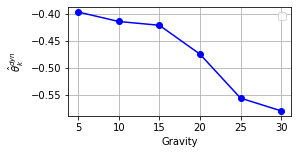

In [139]:
fig = plt.figure(figsize=(4,2))
plt.plot(gravity, embeddings, marker='o', color='b')
plt.xlabel('Gravity')
plt.ylabel(r'$\hat{\theta}_{k}^{dyn}$')
plt.legend()
plt.grid(':')

In [115]:
list(model.dyn_embed_func.parameters())

[Parameter containing:
 tensor([[-0.4138],
         [-0.4208],
         [-0.5553],
         [ 0.4741],
         [-0.5788],
         [ 0.3963],
         [-2.0911],
         [-0.5196],
         [-0.7424],
         [-0.5470],
         [ 1.0937],
         [-0.9748],
         [ 1.8372],
         [-0.6070],
         [ 0.7311],
         [-0.5922],
         [-1.9625],
         [ 0.5205],
         [ 1.6270],
         [ 0.9735],
         [-0.4945],
         [-0.9769],
         [-0.1112],
         [-1.6353],
         [-0.0905],
         [-0.3923],
         [-0.6624],
         [ 1.3552],
         [-0.1739]], requires_grad=True)]

In [8]:
latent_size = 8

In [11]:
from LiLY.modules.metrics.correlation import correlation

In [14]:
z, mu, logvar = model.forward(batch)
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,0,:].detach().cpu().numpy().T
B = batch['yt'][:,0,:].detach().cpu().numpy().T
result = np.zeros(A.shape)
result[:B.shape[0],:B.shape[1]] = B
for i in range(len(A) - len(B)):
    result[B.shape[0] + i, :] = np.random.normal(size=B.shape[1])
    
corr_sorted, sort_idx, mu_sorted = correlation(A, result, method='Spearman')

In [15]:
figure_path = '/home/weiran/figs/'
from matplotlib.backends.backend_pdf import PdfPages

In [30]:
col_ind = sort_idx[:3].astype('int')
print('Permutation:', col_ind)

Permutation: [7 0 6]


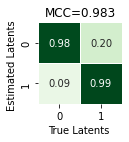

In [31]:
with PdfPages(figure_path + '/mcc_cartpole.pdf') as pdf:
    fig = plt.figure(figsize=(1.5,1.5))
    sns.heatmap(np.abs(corr_sorted[:2,:2]), vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("True Latents ") 
    plt.ylabel("Estimated Latents ")
    plt.title("MCC=%.3f"%np.abs(np.diag(corr_sorted)[:2]).mean())
    pdf.savefig(fig, bbox_inches="tight")

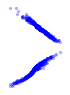

In [33]:
with PdfPages(figure_path + '/xy_cartpole.pdf') as pdf:
    fig, axs = plt.subplots(2,1, figsize=(1,1.5))
    for i in range(2):
        ax = axs[i]
        ax.scatter(B.T[:,i], A.T[:,col_ind[i]], s=5, color='b', alpha=0.25)
        ax.axis('off')
    pdf.savefig(fig, bbox_inches="tight")

In [112]:
list(model.dyn_embed_func.parameters())

[Parameter containing:
 tensor([[-0.4138],
         [-0.4208],
         [-0.5553],
         [ 0.4741],
         [-0.5788],
         [ 0.3963],
         [-2.0911],
         [-0.5196],
         [-0.7424],
         [-0.5470],
         [ 1.0937],
         [-0.9748],
         [ 1.8372],
         [-0.6070],
         [ 0.7311],
         [-0.5922],
         [-1.9625],
         [ 0.5205],
         [ 1.6270],
         [ 0.9735],
         [-0.4945],
         [-0.9769],
         [-0.1112],
         [-1.6353],
         [-0.0905],
         [-0.3923],
         [-0.6624],
         [ 1.3552],
         [-0.1739]], requires_grad=True)]

In [106]:
model.dyn_embed_func(torch.LongTensor((0,1,2,3,4,5,6,7,8)))

tensor([[-0.4138],
        [-0.4208],
        [-0.5553],
        [ 0.4741],
        [-0.5788],
        [ 0.3963],
        [-2.0911],
        [-0.5196],
        [-0.7424]], grad_fn=<EmbeddingBackward>)

In [67]:
fixed_img = torch.tensor(data.__getitem__(205)['xt'], device='cpu')
x_recon_img, mu_img, logvar_img, z_img = model.net(fixed_img)

In [68]:
from torchvision.utils import save_image, make_grid

In [69]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


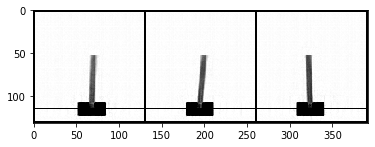

In [70]:
show(make_grid(x_recon_img))

In [92]:
from torch.distributions.normal import Normal
lowest_prob = 0.05
n_steps = 4
normals = [Normal(z[:, i].mean(), z[:, i].std()) for i in range(8)]
interpolation = torch.linspace(lowest_prob, 1 - lowest_prob, steps=n_steps)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


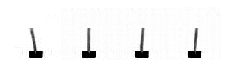

In [95]:
from torch.distributions.normal import Normal
traverse_idx = col_ind[1]
with PdfPages(figure_path + '/traversal_cart_%d.pdf'%traverse_idx) as pdf:
    mus = normals[traverse_idx].icdf(interpolation)
    samples = [ ]
    for step in range(n_steps):
        z_trav = mu_img.clone()
        z_trav[0, traverse_idx] = mus[step]
        sample = model.net._decode(z_trav).data
        samples.append(sample[0].detach().cpu())
    fig = plt.figure(figsize=(n_steps*1,1))
    show(make_grid(samples, pad_value=1, nrow=n_steps))
    plt.axis('off');
    pdf.savefig(fig, bbox_inches="tight")

In [72]:
mu_img = mu_img.detach()

In [82]:
mu_img = mu_img[0:1]

In [38]:
x_recon_img.min()

tensor(-1.2232, grad_fn=<MinBackward1>)

In [36]:
fixed_img[0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [35]:
x_recon_img.shape

torch.Size([3, 1, 128, 128])

In [10]:
z, mu, logvar = model.forward(batch)
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,2,:].detach().cpu().numpy()
B = batch['yt'][:,2,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

ValueError: could not broadcast input array from shape (2,) into shape (8,)

In [ ]:
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

In [33]:
figure_path = '/home/weiran/figs/'

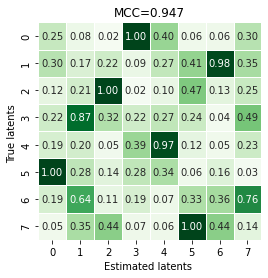

In [34]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mcc_change.pdf') as pdf:
    fig = plt.figure(figsize=(4,4))
    sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated latents ") 
    plt.ylabel("True latents ") 
    plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());
    pdf.savefig(fig, bbox_inches="tight")

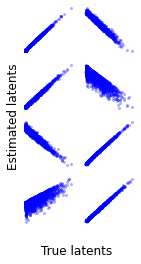

In [35]:
fig, axs = plt.subplots(4,2, figsize=(2,4))
with PdfPages(figure_path + '/scatter_change.pdf') as pdf:
    for i in range(8):
        row = i // 2
        col = i % 2
        ax = axs[row,col]
        ax.scatter(B[:,i], A[:,i], s=4, color='b', alpha=0.25)
        ax.axis('off')
    #     ax.set_xlabel('Ground truth latent')
    #     ax.set_ylabel('Estimated latent')
    #     ax.grid('..')
    # fig.tight_layout()
    fig.supxlabel('True latents')
    fig.supylabel('Estimated latents')
    pdf.savefig(fig, bbox_inches="tight")

In [159]:
class FewShotTransfer(nn.Module):
    
    def __init__(self, vae_model, embed_dims=2):
        super().__init__()
        self.model = vae_model
        for param in self.model.parameters():
            # Freeze
            param.requires_grad = False
        self.embedding = nn.Parameter(torch.zeros(1,embed_dims))
    
    def forward(self, x):
        batch_size = x['yt'].shape[0]
        embeddings = self.embedding.repeat(batch_size, 1)
        loss = self.model.transfer(x, embeddings)
        return loss

In [235]:
shots = 16

In [236]:
target_data = CartpoleDataset(directory = '/srv/data/lily/data', 
                       dataset='cartpole')
num_validation_samples = 2500
train_data, val_data = random_split(target_data, [len(target_data)-num_validation_samples, num_validation_samples])
target_train_loader = DataLoader(train_data, batch_size=shots, shuffle=False, pin_memory=True)
target_val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [237]:
batch = next(iter(target_train_loader))
batch_size = batch['xt'].shape[0]

In [238]:
# for key in batch:
#     batch[key] = batch[key].cuda()

In [255]:
transfer_model = FewShotTransfer(model, 1)
# transfer_model = transfer_model.cuda()

In [256]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), 
                             lr=0.001)

In [257]:
transfer_model = transfer_model.cpu()

In [258]:
for i in range(100):
    loss = transfer_model(batch)
    print(loss.detach(), transfer_model.embedding.detach().cpu())
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(9.6823) tensor([[0.]])
tensor(9.6823) tensor([[-0.0010]])
tensor(9.6823) tensor([[-0.0020]])
tensor(9.6823) tensor([[-0.0030]])
tensor(9.6823) tensor([[-0.0040]])
tensor(9.6822) tensor([[-0.0050]])
tensor(9.6822) tensor([[-0.0060]])
tensor(9.6822) tensor([[-0.0070]])
tensor(9.6822) tensor([[-0.0079]])
tensor(9.6822) tensor([[-0.0089]])
tensor(9.6822) tensor([[-0.0098]])
tensor(9.6822) tensor([[-0.0108]])
tensor(9.6822) tensor([[-0.0117]])
tensor(9.6822) tensor([[-0.0127]])
tensor(9.6822) tensor([[-0.0136]])
tensor(9.6822) tensor([[-0.0146]])
tensor(9.6822) tensor([[-0.0156]])
tensor(9.6822) tensor([[-0.0165]])
tensor(9.6822) tensor([[-0.0175]])
tensor(9.6822) tensor([[-0.0185]])
tensor(9.6822) tensor([[-0.0195]])
tensor(9.6822) tensor([[-0.0204]])
tensor(9.6822) tensor([[-0.0214]])
tensor(9.6822) tensor([[-0.0224]])
tensor(9.6821) tensor([[-0.0234]])
tensor(9.6821) tensor([[-0.0244]])
tensor(9.6821) tensor([[-0.0254]])
tensor(9.6821) tensor([[-0.0264]])
tensor(9.6821) tensor([[-

In [ ]:
16 samples: 0.4605


In [ ]:
[ 0.4463, -0.1148]

In [77]:
transfer_model(batch)

tensor(2.5160, grad_fn=<AddBackward0>)

In [ ]:
NL + Generalized Gaussian Noise

In [188]:
theta_dyn = np.zeros((5,2))
for d_idx in range(5):
    W2 = np.load('/srv/data/lily/data/pnl_modular_5/source/W2_%d.npy'%d_idx)
    theta_dyn[d_idx, 0] = W2[1,2]
    theta_dyn[d_idx, 1] = W2[3,4]

In [189]:
theta_hat = model.dyn_embed_func(torch.LongTensor([0,1,2,3,4])).detach().numpy()

In [190]:
from matplotlib.patches import FancyArrowPatch 

In [191]:
from matplotlib.patches import FancyArrowPatch 

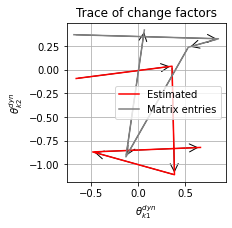

In [345]:
theta_hat = theta_hat.detach().numpy()
theta_dyn = theta_dyn.detach().numpy()

fig, ax = plt.subplots(figsize=(3,3))
ax.set_aspect("equal")
ax.plot(theta_hat[:,0], theta_hat[:,1], color='red', label='Estimated')
ax.plot(theta_dyn[:,0], theta_dyn[:,1], color='gray', label='Matrix entries')
arrow(theta_hat[:,0], theta_hat[:,1], ax, 3)
arrow(theta_dyn[:,0], theta_dyn[:,1], ax, 3)
plt.tight_layout()
plt.legend()
plt.grid()
plt.xlabel(r'$\theta_{k1}^{dyn}$')
plt.ylabel(r'$\theta_{k2}^{dyn}$')
plt.title('Trace of change factors')
def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)

In [359]:
np.linalg.inv(theta_hat.T @ theta_hat) @ (theta_hat.T @ theta_dyn)

array([[ 0.7634366 ,  0.5584793 ],
       [-0.02744316,  0.16442966]], dtype=float32)

In [355]:
R = np.random.rand(2,2)

In [357]:
(theta_hat - theta_dyn @ R)

array([[-0.69237621, -0.19672908],
       [-0.36935343, -0.41940991],
       [-0.10224308, -1.41819704],
       [ 0.48799991, -0.15370551],
       [ 0.2149604 , -1.14880499]])

In [ ]:
5,2 

In [358]:
theta_dyn.shape

(5, 2)

In [290]:
rotation

Parameter containing:
tensor([-0.2278], requires_grad=True)

In [270]:
rotation.grad

tensor([0.])

In [255]:
rotation.data.add_(-1, rotation.grad)

/tmp/ipykernel_2979/960937127.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.data.add_(-1, rotation.grad)


TypeError: add_() takes 1 positional argument but 2 were given

/tmp/ipykernel_2979/587205299.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.grad[0]


TypeError: 'NoneType' object is not subscriptable

In [244]:
rotation.grad

/tmp/ipykernel_2979/1116664041.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.grad


In [240]:
rotation.grad[0]

tensor(2.5513)

In [225]:
rotation.grad

tensor([0.2551])

In [217]:
loss

tensor(0.4698, grad_fn=<MseLossBackward>)

In [207]:
rotation_matrix

tensor([[1., 0.],
        [-0., 1.]], grad_fn=<CopySlices>)

In [202]:
rotation

Parameter containing:
tensor([0.], requires_grad=True)

In [194]:
theta_hat.shape

(5, 2)

In [167]:
MeanMat = np.load('/srv/data/lily/data/pnl_modular_5/source/meanMat.npy')
VarMat = np.load('/srv/data/lily/data/pnl_modular_5/source/varMat.npy')

In [181]:
theta_obs = np.concatenate((MeanMat,VarMat), axis=-1)

In [182]:
theta_hat = model.obs_embed_func(torch.LongTensor([0,1,2,3,4])).detach().numpy()

Text(0, 0.5, '$\\theta_{1k}^{obs}$')

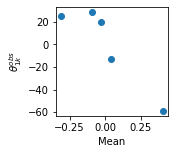

In [185]:
plt.figure(figsize=(2,2))
plt.scatter(theta_obs[:,0], theta_hat[:,0])
plt.xlabel('Mean')
plt.ylabel(r'$\theta_{1k}^{obs}$')

Text(0, 0.5, '$\\theta_{2k}^{obs}$')

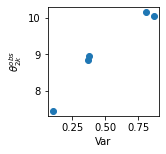

In [187]:
plt.figure(figsize=(2,2))
plt.scatter(theta_obs[:,1], theta_hat[:,1])
plt.xlabel('Var')
plt.ylabel(r'$\theta_{2k}^{obs}$')

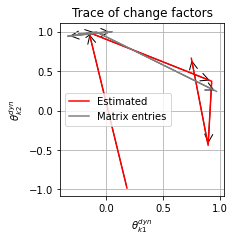

In [165]:
fig, ax = plt.subplots(figsize=(3,3))
# ax.set_aspect("equal")
plt.tight_layout()
ax.plot(theta_hat[:,0], theta_hat[:,1], color='red', label='Estimated')
ax.plot(theta_obs[:,0], theta_obs[:,1], color='gray', label='Matrix entries')
arrow(theta_hat[:,0], theta_hat[:,1], ax, 3)
arrow(theta_obs[:,0], theta_obs[:,1], ax, 3)
plt.legend()
plt.grid()
plt.xlabel(r'$\theta_{k1}^{dyn}$')
plt.ylabel(r'$\theta_{k2}^{dyn}$')
plt.title('Trace of change factors')
def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)